In [52]:
import torch
import os
import time
import torch.nn as nn
from cell import graph_utils, utils
from cell.Word2vec import prepare_vocab, dataloader, wv
from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk

os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
data_dir = "/Users/fahimehb/Documents/NPP_GNN_project/dat/"

In [3]:
walk_dir = "/Users/fahimehb/Documents/GNN/dat/walks/jsd/N_1_l_10000_p_1_q_1"

In [4]:
cl_df = pd.read_csv("/Users/fahimehb/Documents/GNN/dat/cl_df_150cl.csv", index_col="Unnamed: 0")
JSD = pd.read_csv(data_dir + "/jsd_python_recomputed.csv", index_col="Unnamed: 0")

In [5]:
JSD.head()

,L2/3 IT VISp Rrad,L2/3 IT VISp Adamts2,L2/3 IT VISp Agmat,L2/3 IT ALM Sla,L2/3 IT ALM Ptrf,L2/3 IT ALM Macc1 Lrg1,L4 IT VISp Rspo1,L5 IT VISp Hsd11b1 Endou,L5 IT VISp Whrn Tox2,L5 IT VISp Batf3,...,Pvalb Calb1 Sst,Pvalb Akr1c18 Ntf3,Pvalb Sema3e Kank4,Pvalb Gpr149 Islr,Pvalb Reln Itm2a,Pvalb Reln Tac1,Pvalb Tpbg,Pvalb Vipr2,Meis2 Adamts19,CR Lhx5
L2/3 IT VISp Rrad,0.000000,0.301102,0.298124,0.368229,0.380890,0.374299,0.443092,0.424371,0.451549,0.460754,...,0.652734,0.672896,0.681676,0.662296,0.670632,0.645035,0.642742,0.651381,0.931339,0.960910
L2/3 IT VISp Adamts2,0.301102,0.000000,0.188236,0.214161,0.270566,0.258561,0.400160,0.355376,0.366944,0.384346,...,0.594207,0.612206,0.620531,0.611896,0.613267,0.587671,0.586599,0.607065,0.926450,0.950134
L2/3 IT VISp Agmat,0.298124,0.188236,0.000000,0.226926,0.199509,0.200723,0.338924,0.310884,0.338887,0.349076,...,0.585534,0.599034,0.603322,0.595078,0.597362,0.577257,0.572084,0.596130,0.939060,0.964855
L2/3 IT ALM Sla,0.368229,0.214161,0.226926,0.000000,0.184497,0.175146,0.434578,0.367249,0.361779,0.396239,...,0.597412,0.607766,0.604308,0.614858,0.609763,0.595626,0.581946,0.616643,0.955213,0.983243
L2/3 IT ALM Ptrf,0.380890,0.270566,0.199509,0.184497,0.000000,0.184492,0.416107,0.355162,0.357739,0.377770,...,0.591342,0.600843,0.597574,0.601609,0.600725,0.587534,0.575117,0.603320,0.950286,0.986370


In [6]:
cl_df = cl_df.set_index("cluster_id")
cl_df.head()

,cluster_label,cluster_color,subclass_id,subclass_label,subclass_color,class_id,class_label,class_color,dendcluster_id,dendcluster_label,dendcluster_color,mu_x,mu_y
cluster_id,,,,,,,,,,,,,
61,L2/3 IT VISp Rrad,#D9F077,7,L2/3 IT,#94D9A1,2,Glutamatergic,#27AAE1,1.0,L2/3 IT VISp Rrad,#D9F077,0.155991,-0.443063
62,L2/3 IT VISp Adamts2,#A6E6A9,7,L2/3 IT,#94D9A1,2,Glutamatergic,#27AAE1,2.0,L2/3 IT VISp Adamts2,#A6E6A9,0.333016,-0.540455
63,L2/3 IT VISp Agmat,#7AE6AB,7,L2/3 IT,#94D9A1,2,Glutamatergic,#27AAE1,3.0,L2/3 IT VISp Agmat,#7AE6AB,0.323327,-0.576560
64,L2/3 IT ALM Sla,#82AD7D,7,L2/3 IT,#94D9A1,2,Glutamatergic,#27AAE1,4.0,L2/3 IT ALM Sla,#82AD7D,0.498074,-0.641736
65,L2/3 IT ALM Ptrf,#B8FFCA,7,L2/3 IT,#94D9A1,2,Glutamatergic,#27AAE1,5.0,L2/3 IT ALM Ptrf,#B8FFCA,0.481052,-0.634547


In [7]:
types = JSD.index.tolist()
type_id = []

for t in types:
    type_id.append(str(cl_df[cl_df['cluster_label']==t].index.tolist()[0]))

In [8]:
JSD.columns = type_id
JSD.index = type_id

In [9]:
JSD.head()

,61,62,63,64,65,66,67,68,69,70,...,54,53,55,56,58,57,59,60,116,117
61,0.000000,0.301102,0.298124,0.368229,0.380890,0.374299,0.443092,0.424371,0.451549,0.460754,...,0.652734,0.672896,0.681676,0.662296,0.670632,0.645035,0.642742,0.651381,0.931339,0.960910
62,0.301102,0.000000,0.188236,0.214161,0.270566,0.258561,0.400160,0.355376,0.366944,0.384346,...,0.594207,0.612206,0.620531,0.611896,0.613267,0.587671,0.586599,0.607065,0.926450,0.950134
63,0.298124,0.188236,0.000000,0.226926,0.199509,0.200723,0.338924,0.310884,0.338887,0.349076,...,0.585534,0.599034,0.603322,0.595078,0.597362,0.577257,0.572084,0.596130,0.939060,0.964855
64,0.368229,0.214161,0.226926,0.000000,0.184497,0.175146,0.434578,0.367249,0.361779,0.396239,...,0.597412,0.607766,0.604308,0.614858,0.609763,0.595626,0.581946,0.616643,0.955213,0.983243
65,0.380890,0.270566,0.199509,0.184497,0.000000,0.184492,0.416107,0.355162,0.357739,0.377770,...,0.591342,0.600843,0.597574,0.601609,0.600725,0.587534,0.575117,0.603320,0.950286,0.986370


In [10]:
edge_list = graph_utils.build_edge_list(weight_matrix=JSD, threshold=0, directed=False)

Upper triangle and diag are used as weights


In [11]:
nxg = graph_utils.build_nx_graph(source_target_weight=edge_list, directed=False)

In [12]:
sg = StellarGraph(nxg)

In [13]:
rw = BiasedRandomWalk(sg)

In [14]:
# nodes = list(sg.nodes())

# walks = rw.run(nodes,
#                length=10000,
#                n=1,
#                p=1,         
#                q=1,         
#                weighted=True)

In [16]:
# utils.write_list_of_lists_to_csv(walk_dir, "walk_0.csv", walks)

In [17]:
walks = utils.read_list_of_lists_from_csv(walk_dir, "walk_0.csv")

In [18]:
vocabulary = prepare_vocab.get_vocabulary(walks)

print(f'lenght of vocabulary: {len(vocabulary)}')

word_2_index = prepare_vocab.get_word2idx(vocabulary)
index_2_word = prepare_vocab.get_idx2word(vocabulary)

lenght of vocabulary: 117


In [19]:
context_tuple_list = prepare_vocab.get_word_context_tuples(walks, window=2)

There are 3509532 pairs of target and context words


In [20]:
dataset = dataloader.WalkDataset(context_tuple_list, 
                                 word_2_index)

data_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                          batch_size=100, 
                                          shuffle=True,
                                          num_workers=1)

In [21]:
vocab_size = len(vocabulary)
embedding_size = 3
learning_rate = 0.001
n_epochs = 100

In [22]:
criterion = nn.CrossEntropyLoss()

model = wv.Word2Vec(embedding_size=embedding_size, vocab_size=vocab_size)

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
n_total_steps = len(data_loader)

training_loss = []


for epoch in range(n_epochs):
    t0 = time.time()
    losses = []
    for i, (target, context) in enumerate(data_loader):
        target = target.to(device)
        context = context.to(device)
        prediction = model(context)
        loss = criterion(prediction, target)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    t1 = time.time()
    #print('time is %.2f' % (t1 - t0))
        
    training_loss.append(np.mean(losses)) 
    print(f'epoch: {epoch+1}/{n_epochs}, loss:{np.mean(losses):.4f}')

epoch: 1/100, loss:4.7540
epoch: 2/100, loss:4.7484
epoch: 3/100, loss:4.7482
epoch: 4/100, loss:4.7480
epoch: 5/100, loss:4.7479
epoch: 6/100, loss:4.7479
epoch: 7/100, loss:4.7479
epoch: 8/100, loss:4.7479
epoch: 9/100, loss:4.7479
epoch: 10/100, loss:4.7479
epoch: 11/100, loss:4.7479
epoch: 12/100, loss:4.7479
epoch: 13/100, loss:4.7479
epoch: 14/100, loss:4.7479
epoch: 15/100, loss:4.7479
epoch: 16/100, loss:4.7479
epoch: 17/100, loss:4.7479
epoch: 18/100, loss:4.7479
epoch: 19/100, loss:4.7479
epoch: 20/100, loss:4.7479
epoch: 21/100, loss:4.7479
epoch: 22/100, loss:4.7479
epoch: 23/100, loss:4.7479
epoch: 24/100, loss:4.7479
epoch: 25/100, loss:4.7479
epoch: 26/100, loss:4.7479
epoch: 27/100, loss:4.7479
epoch: 28/100, loss:4.7479
epoch: 29/100, loss:4.7479
epoch: 30/100, loss:4.7479
epoch: 31/100, loss:4.7479
epoch: 32/100, loss:4.7479
epoch: 33/100, loss:4.7479
epoch: 34/100, loss:4.7479
epoch: 35/100, loss:4.7479
epoch: 36/100, loss:4.7479
epoch: 37/100, loss:4.7479
epoch: 38/

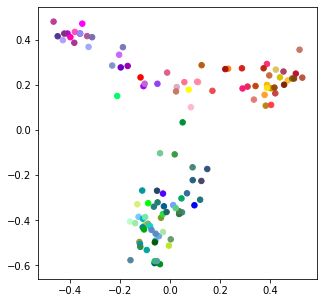

In [30]:
# from cell import analysis, plot_utils
# #cldf = utils.read_visp_npp_cldf()
# vectors = model.embeddings.weight.detach().numpy()
# data = analysis.summarize_walk_embedding_results(gensim_dict={"model": vectors},
#                                                  index = index_2_word.values(),
#                                                  ndim=2, 
#                                                  cl_df=cl_df)

# fig= plot_utils.plot_embedding(data=data, 
#                           cl_df=cl_df,
#                           plot_dim=2, 
#                           plot_size=(5,5), 
#                           annotation=False)


In [31]:
fig.savefig("/Users/fahimehb/Documents/GNN/dat/jsd_results/wv_3d.png", dpi=750)


In [50]:
from cell import analysis, plot_utils
#cldf = utils.read_visp_npp_cldf()
%matplotlib qt5
vectors = model.embeddings.weight.detach().numpy()
data = analysis.summarize_walk_embedding_results(gensim_dict={"model": vectors},
                                                 index = index_2_word.values(),
                                                 ndim=3, 
                                                 cl_df=cl_df)

fig= plot_utils.plot_embedding(data=data, 
                          cl_df=cl_df,
                          plot_dim=3, 
                          plot_size=(5,5), 
                          annotation=True)


In [51]:
analysis.get_closest_node_label(vectors, list(index_2_word.values()), "8", 30, cl_df)

closest nodes to : Sncg Slc17a8
------------------------------------------

                    cluster_label
cluster_id                       
2              Lamp5 Fam19a1 Pax6
4                Lamp5 Ntn1 Npy2r
12                 Serpinf1 Clrn1
5               Lamp5 Plch2 Dock5
9                  Sncg Vip Nptx2
10                     Sncg Gpr50
3           Lamp5 Fam19a1 Tmem182
1                     Lamp5 Krt73
7                      Lamp5 Lhx6
30                      Sst Chodl
11                 Sncg Vip Itih5
15                Vip Igfbp6 Pltp
117                       CR Lhx5
6                      Lamp5 Lsp1
116                Meis2 Adamts19
33                 Sst Tac1 Tacr3
14               Vip Igfbp6 Car10
51                   Pvalb Gabrg1
97          L5 NP VISp Trhr Cpne7
50                        Sst Nts
38                 Sst Myh8 Fibin
60                    Pvalb Vipr2
17             Vip Arhgap36 Hmcn1
53             Pvalb Akr1c18 Ntf3
13              Serpinf1 Aqp5 Vip
20    

['Lamp5 Fam19a1 Pax6',
 'Lamp5 Ntn1 Npy2r',
 'Serpinf1 Clrn1',
 'Lamp5 Plch2 Dock5',
 'Sncg Vip Nptx2',
 'Sncg Gpr50',
 'Lamp5 Fam19a1 Tmem182',
 'Lamp5 Krt73',
 'Lamp5 Lhx6',
 'Sst Chodl',
 'Sncg Vip Itih5',
 'Vip Igfbp6 Pltp',
 'CR Lhx5',
 'Lamp5 Lsp1',
 'Meis2 Adamts19',
 'Sst Tac1 Tacr3',
 'Vip Igfbp6 Car10',
 'Pvalb Gabrg1',
 'L5 NP VISp Trhr Cpne7',
 'Sst Nts',
 'Sst Myh8 Fibin',
 'Pvalb Vipr2',
 'Vip Arhgap36 Hmcn1',
 'Pvalb Akr1c18 Ntf3',
 'Serpinf1 Aqp5 Vip',
 'Vip Lmo1 Myl1',
 'Sst Calb2 Necab1',
 'Vip Lect1 Oxtr',
 'Sst Chrna2 Ptgdr',
 'Pvalb Th Sst']

In [55]:
cl_df.loc['32']

cluster_label        Sst Tac1 Htr1d
cluster_color               #804811
subclass_id                       5
subclass_label                  Sst
subclass_color              #F15A29
class_id                          1
class_label               GABAergic
class_color                 #EF4136
dendcluster_id                   87
dendcluster_label    Sst Tac1 Htr1d
dendcluster_color           #804811
mu_x                      -0.209201
mu_y                        1.00029
Name: 32, dtype: object